### Importing packages

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import torch
import torch.nn as nn
import torch.optim as optim
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

### Fetching Dataset

In [2]:
air_quality = fetch_ucirepo(id=360) # https://archive.ics.uci.edu/dataset/360/air+quality

X = air_quality.data.features
y = air_quality.data.targets

In [3]:
type(X), type(y)

(pandas.core.frame.DataFrame, NoneType)

*Because target features is NoneType, we will treat the X as entire dataset then preprocess that dataset and form our target or targets*

In [4]:
#  Replace -200 with NaN
X.replace(-200, np.nan, inplace=True)

### EDA

**Dataset Shape**

In [5]:
X.shape

(9357, 15)

**Column Types and Memory Usage**

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         7674 non-null   float64
 3   PT08.S1(CO)    8991 non-null   float64
 4   NMHC(GT)       914 non-null    float64
 5   C6H6(GT)       8991 non-null   float64
 6   PT08.S2(NMHC)  8991 non-null   float64
 7   NOx(GT)        7718 non-null   float64
 8   PT08.S3(NOx)   8991 non-null   float64
 9   NO2(GT)        7715 non-null   float64
 10  PT08.S4(NO2)   8991 non-null   float64
 11  PT08.S5(O3)    8991 non-null   float64
 12  T              8991 non-null   float64
 13  RH             8991 non-null   float64
 14  AH             8991 non-null   float64
dtypes: float64(13), object(2)
memory usage: 1.1+ MB


**Check for Duplicated Rows**

In [7]:
duplicated_rows = X.duplicated().sum()

*Number of Duplicated Rows*

In [8]:
duplicated_rows

np.int64(0)

**Summary statistics for numerical columns**

In [9]:
X.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,7674.000000,8991.000000,914.000000,8991.000000,8991.000000,7718.000000,8991.000000,7715.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000
mean,2.152750,1099.833166,218.811816,10.083105,939.153376,246.896735,835.493605,113.091251,1456.264598,1022.906128,18.317829,49.234201,1.025530
std,1.453252,217.080037,204.459921,7.449820,266.831429,212.979168,256.817320,48.370108,346.206794,398.484288,8.832116,17.316892,0.403813
min,0.100000,647.000000,7.000000,0.100000,383.000000,2.000000,322.000000,2.000000,551.000000,221.000000,-1.900000,9.200000,0.184700
25%,1.100000,937.000000,67.000000,4.400000,734.500000,98.000000,658.000000,78.000000,1227.000000,731.500000,11.800000,35.800000,0.736800
50%,1.800000,1063.000000,150.000000,8.200000,909.000000,180.000000,806.000000,109.000000,1463.000000,963.000000,17.800000,49.600000,0.995400
75%,2.900000,1231.000000,297.000000,14.000000,1116.000000,326.000000,969.500000,142.000000,1674.000000,1273.500000,24.400000,62.500000,1.313700
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


**Missing Values**

In [10]:
missing_values = X.isnull().mean() * 100

# Display nicely
missing_values = pd.DataFrame({
    'Missing %': missing_values.sort_values(ascending=False) 
})

In [11]:
missing_values

,Missing %
NMHC(GT),90.231912
CO(GT),17.986534
NO2(GT),17.548360
NOx(GT),17.516298
PT08.S1(CO),3.911510
C6H6(GT),3.911510
PT08.S2(NMHC),3.911510
PT08.S3(NOx),3.911510
PT08.S4(NO2),3.911510
PT08.S5(O3),3.911510


**Plot Missing Values as Heatmap**

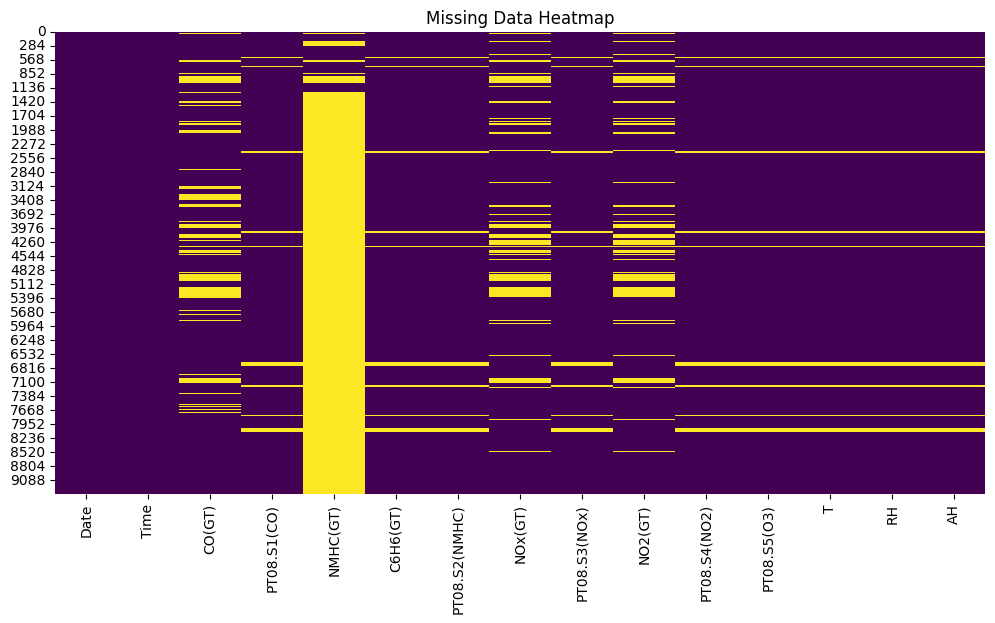

In [12]:
plt.figure(figsize=(12,6))
sns.heatmap(X.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

**Check Distributions for Numerical Columns**

In [13]:
X.describe().T[['mean', '50%', 'std']]

,mean,50%,std
CO(GT),2.152750,1.8000,1.453252
PT08.S1(CO),1099.833166,1063.0000,217.080037
NMHC(GT),218.811816,150.0000,204.459921
C6H6(GT),10.083105,8.2000,7.449820
PT08.S2(NMHC),939.153376,909.0000,266.831429
NOx(GT),246.896735,180.0000,212.979168
PT08.S3(NOx),835.493605,806.0000,256.817320
NO2(GT),113.091251,109.0000,48.370108
PT08.S4(NO2),1456.264598,1463.0000,346.206794
PT08.S5(O3),1022.906128,963.0000,398.484288


**Drop NMHC(GT) due to excessive missing values**

In [14]:
X.drop(columns=['NMHC(GT)'], inplace=True)

**Merge Date and Time columns to Datetime then set it as index and drop Date and Time columns**

In [15]:
X['Datetime'] = pd.to_datetime(X['Date'] + ' ' + X['Time'], format='mixed', errors='coerce')
X.drop(columns=['Date', 'Time'], inplace=True)
X.set_index('Datetime', inplace=True)

**New Shape After Dropping Fully Missing Columns**

In [16]:
X.shape

(9357, 12)

**Check the Distributions for Each Column and Plot Histograms**

In [17]:
X.hist(figsize=(200,150), bins=30)
plt.suptitle('Feature Distributions')
plt.show()

**????**

In [18]:
X.skew().sort_values()

RH              -0.037928
PT08.S4(NO2)     0.205389
AH               0.251388
T                0.309357
PT08.S2(NMHC)    0.561566
NO2(GT)          0.621714
PT08.S5(O3)      0.627864
PT08.S1(CO)      0.755907
PT08.S3(NOx)     1.101729
C6H6(GT)         1.361532
CO(GT)           1.369753
NOx(GT)          1.715781
dtype: float64

*Check if a column has sequential missing values*

In [19]:
X.isnull().sum().sort_values(ascending=False)

CO(GT)           1683
NO2(GT)          1642
NOx(GT)          1639
PT08.S1(CO)       366
C6H6(GT)          366
PT08.S2(NMHC)     366
PT08.S3(NOx)      366
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
dtype: int64

In [20]:
for col in X.columns:
    if X[col].skew() < -0.5 or X[col].skew() > 0.5:
        X.loc[:,col] = X[col].fillna(X[col].median()) # Median for skewed data
    else:
        X.loc[:,col] = X[col].fillna(X[col].mean()) # Mean for normal data

***Total Missing Values Remaining***

In [21]:
X.isnull().sum().sum()

np.int64(0)

In [22]:
X.head()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Datetime,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


**Seperate Target Variable and Drop from Features**

In [23]:
y = X['T']
X.drop(columns=['T'], inplace=True)

**Check Final Shapes**

In [24]:
print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

Feature matrix shape: (9357, 11)
Target vector shape: (9357,)


In [25]:
scaler = StandardScaler()
X[X.columns] = scaler.fit_transform(X)

In [26]:
X.head()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),RH,AH
Datetime,,,,,,,,,,,
2004-03-10 18:00:00,0.386029,1.228781,0.258577,0.412925,-0.354617,0.880318,0.014261,0.694669,0.633214,-0.019689,-0.676404
2004-03-10 19:00:00,-0.067502,0.909382,-0.083356,0.065082,-0.677560,1.348952,-0.463597,0.302742,-0.124277,-0.090386,-0.758008
2004-03-10 20:00:00,0.083675,1.426057,-0.138065,0.003922,-0.534030,1.213922,0.037016,0.290955,0.136750,0.280772,-0.695605
2004-03-10 21:00:00,0.083675,1.303934,-0.110711,0.038324,-0.323861,1.023291,0.219057,0.376413,0.466873,0.634256,-0.603390
2004-03-10 22:00:00,-0.369856,0.815441,-0.479998,-0.389791,-0.534030,1.472068,0.082526,0.099412,0.228878,0.610691,-0.598084


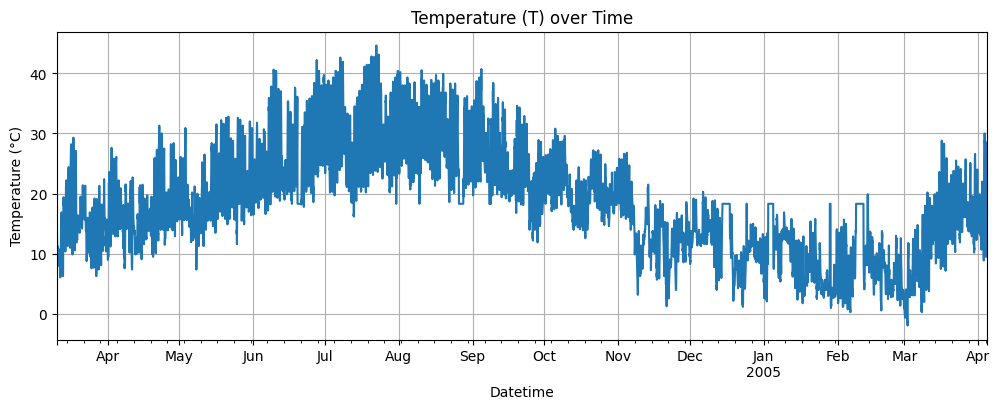

In [27]:
plt.figure(figsize=(12, 4))
y.plot()
plt.title('Temperature (T) over Time')
plt.ylabel('Temperature (°C)')
plt.xlabel('Datetime')
plt.grid(True)
plt.show()

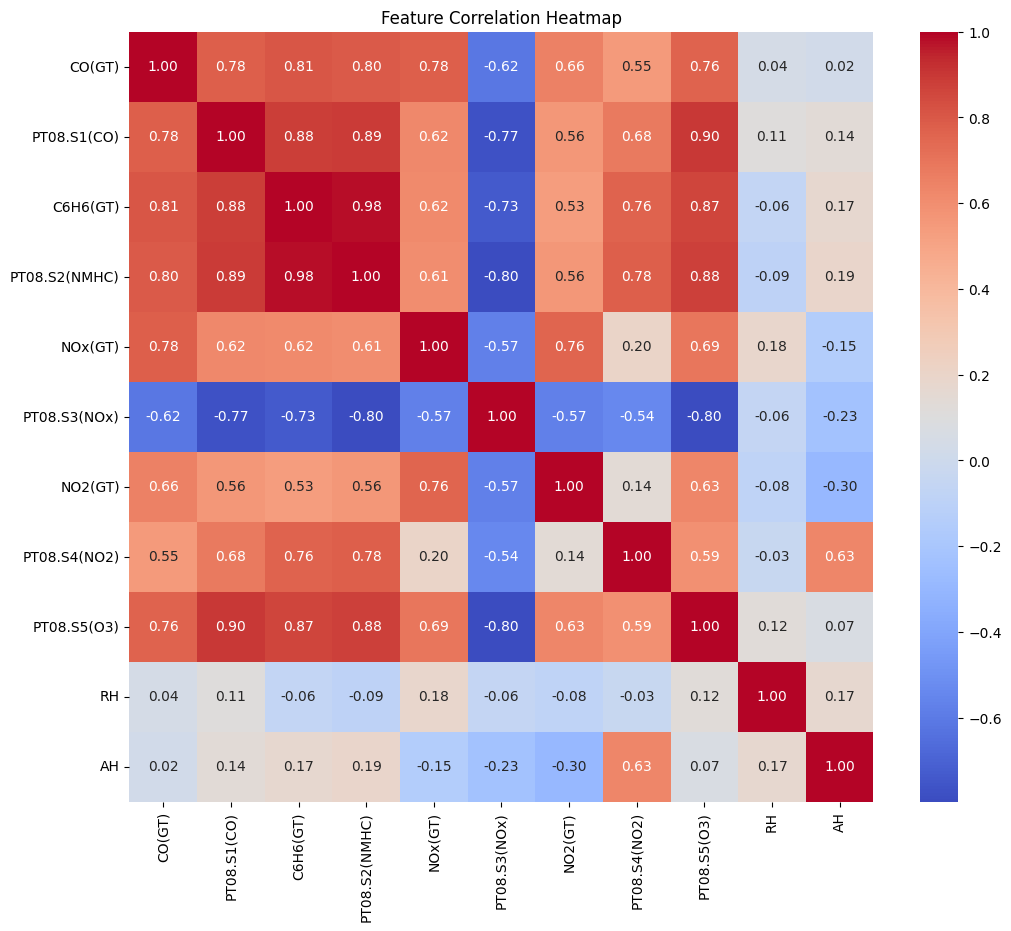

In [28]:
plt.figure(figsize=(12, 10))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()

In [29]:
full_df = X.copy()
full_df['T'] = y

correlations = full_df.corr()['T'].drop('T').sort_values(ascending=False)
print("Top correlated features with T:\n", correlations)

Top correlated features with T:
 AH               0.656397
PT08.S4(NO2)     0.561270
PT08.S2(NMHC)    0.241313
C6H6(GT)         0.198708
PT08.S1(CO)      0.048599
CO(GT)           0.006918
PT08.S5(O3)     -0.027160
PT08.S3(NOx)    -0.145075
NO2(GT)         -0.168362
NOx(GT)         -0.244540
RH              -0.578621
Name: T, dtype: float64


**Plot Target (T) vs Features**

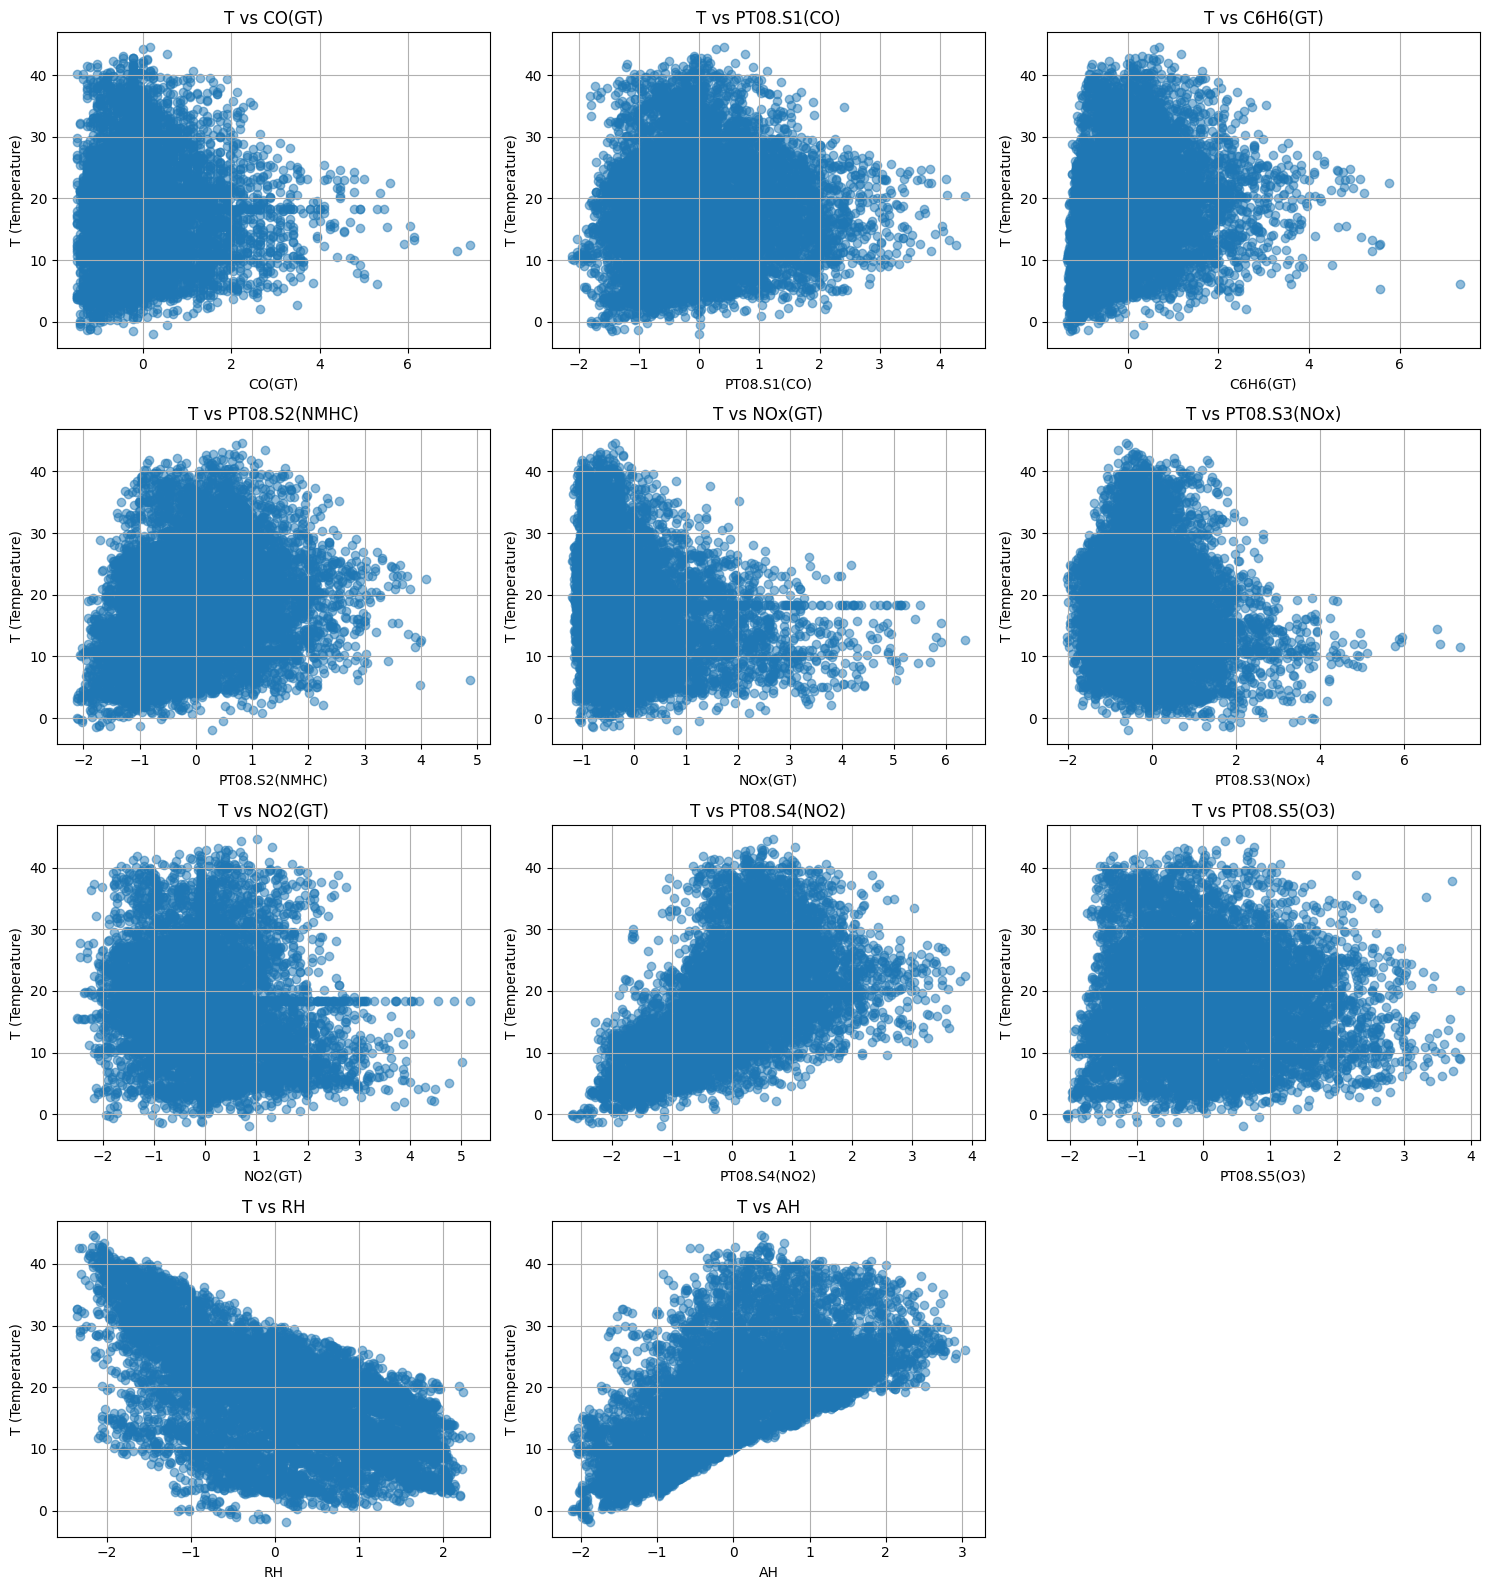

In [30]:
features = X.columns
n_features = len(features)
cols = 3
rows = math.ceil(n_features / cols)

plt.figure(figsize=(cols * 5, rows * 4))
for i, feature in enumerate(features):
    plt.subplot(rows, cols, i + 1)
    plt.scatter(X[feature], y, alpha=0.5)
    plt.title(f'T vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('T (Temperature)')
    plt.grid(True)

plt.tight_layout()
plt.show()

**Splitting dataset**

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# Store results
results = {}

**Random Forest**

In [33]:
rf_params = {'n_estimators': [100, 200], 'max_depth': [None, 10]}
rf = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=3, scoring='r2')
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
joblib.dump(rf.best_estimator_, "random_forest_model.pkl")
results['Random Forest'] = {
    'R2': r2_score(y_test, rf_preds),
    'RMSE': mean_squared_error(y_test, rf_preds) ** 0.5,
    'MAE': mean_absolute_error(y_test, rf_preds)
}

**KNN**

In [34]:
knn_params = {'n_neighbors': [3, 5, 7]}
knn = GridSearchCV(KNeighborsRegressor(), knn_params, cv=3, scoring='r2')
knn.fit(X_train, y_train)
knn_preds = knn.predict(X_test)
joblib.dump(knn.best_estimator_, "knn_model.pkl")
results['KNN'] = {
    'R2': r2_score(y_test, knn_preds),
    'RMSE': mean_squared_error(y_test, knn_preds) ** 0.5,
    'MAE': mean_absolute_error(y_test, knn_preds)
}

**XGBoost**

In [35]:
xgb_params = {'n_estimators': [100, 200], 'max_depth': [3, 6]}
xgb = GridSearchCV(XGBRegressor(random_state=42, verbosity=0), xgb_params, cv=3, scoring='r2')
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)
joblib.dump(xgb.best_estimator_, "xgboost_model.pkl")
results['XGBoost'] = {
    'R2': r2_score(y_test, xgb_preds),
    'RMSE': mean_squared_error(y_test, xgb_preds) ** 0.5,
    'MAE': mean_absolute_error(y_test, xgb_preds)
}

**PyTorch Deep Learning**

In [36]:
class ModelNN(nn.Module):
    def __init__(self, input_size):
        super(ModelNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

# Convert data to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)

# Initialize model, loss, optimizer
model = ModelNN(X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)  # optional

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Evaluation
model.eval()
with torch.no_grad():
    preds = model(X_test_tensor).numpy().flatten()

results['Deep Learning (PyTorch)'] = {
    'R2': r2_score(y_test, preds),
    'RMSE': mean_squared_error(y_test, preds) ** 0.5,
    'MAE': mean_absolute_error(y_test, preds)
}

# Save model
torch.save(model.state_dict(), "deep_learning_model.pth")

Epoch 0, Loss: 402.1906
Epoch 10, Loss: 128.6902
Epoch 20, Loss: 37.2711
Epoch 30, Loss: 15.9081
Epoch 40, Loss: 9.4256
Epoch 50, Loss: 7.5226
Epoch 60, Loss: 6.8134
Epoch 70, Loss: 6.5283
Epoch 80, Loss: 6.1712
Epoch 90, Loss: 5.9768


**Summary**

In [37]:
# Convert results dictionary to DataFrame
results_df = pd.DataFrame(results).T

# Round metrics for cleaner display
results_df = results_df.round(4)

# Display
print("\n--- Model Performance Summary ---")
print(results_df)


--- Model Performance Summary ---
                             R2    RMSE     MAE
Random Forest            0.9994  0.2147  0.1264
KNN                      0.9716  1.4739  1.0396
XGBoost                  0.9985  0.3423  0.2329
Deep Learning (PyTorch)  0.9904  0.8559  0.6204
